In [1]:
%pylab notebook
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/")

### A

In [3]:
from zillow import features,config
reload (features)

<module 'zillow.features' from '../python/zillow/features.pyc'>

In [4]:
def read_error(state,year):
    fname=os.path.join(config.get_state_year_folder2(state,year),'lgbchain_prediction_merged.parq')
    #y=features.get('sale_price_zip5',state,year)
    lati=features.get('longi_lati',state,year)
    month=features.get('month',state,year)
    df=pd.concat([dd.read_parquet(fname)['error'].compute(),lati,month],axis=1).dropna()
    df['year']=(df['month']/100).astype(np.int32)
    df['month']=(df['month']-df['year']*100).astype(np.int32)
    df['abserror']=df['error'].abs()
    return df

In [5]:
def read_state_error(state):
    return pd.concat([read_error(state,year) for year in config.YEARS],0)
        


In [6]:
df = read_state_error('36')

In [7]:
df.shape

(295926, 6)

In [8]:
df[['year','error','abserror']].groupby('year').aggregate(['mean','std','median','count'])

error                             abserror                           
          mean       std    median  count      mean       std    median  count
year                                                                          
2007  0.018649  0.380167 -0.000885  38975  0.234888  0.299502  0.137659  38975
2008  0.026594  0.404087  0.000105  30156  0.239124  0.326820  0.132297  30156
2009  0.043243  0.340130 -0.000597  25405  0.196188  0.281189  0.113919  25405
2010  0.069323  0.405506 -0.000965  33557  0.221128  0.346903  0.112170  33557
2011  0.036148  0.340792 -0.001433  22111  0.188231  0.286381  0.104901  22111
2012  0.031045  0.327717 -0.001017  20603  0.179029  0.276242  0.099590  20603
2013  0.032114  0.329741 -0.001183  23301  0.182457  0.276530  0.102842  23301
2014  0.029165  0.346638 -0.000622  21565  0.191153  0.290633  0.105488  21565
2015  0.035869  0.330213 -0.001568  22224  0.177551  0.280716  0.101655  22224
2016  0.033230  0.310943  0.000092  23133  0.164567  0.265907  0.091679  23133
2017  0.040765  0.323448 -0.000201  24880  0.170976  0.277573  0.092981  24880
2018  0.033809  0.331348 -0.001394  10016  0.178783  0.281013  0.099201  10016

In [22]:
grouped=df[df.year==2018][['month','error','abserror']].groupby('month').aggregate(['mean','std','median','count'])
grouped

error                            abserror                          
           mean       std    median count      mean       std    median count
month                                                                        
1      0.025136  0.356115 -0.010213  2228  0.175148  0.311062  0.092644  2228
2      0.031789  0.297781 -0.003565  1701  0.176518  0.241883  0.098831  1701
3      0.053492  0.328567  0.010631  1878  0.181555  0.278997  0.099714  1878
4      0.022115  0.320930 -0.002811  1654  0.176727  0.268764  0.103601  1654
5      0.036513  0.346654 -0.000876  1814  0.185115  0.295325  0.102629  1814
6      0.034123  0.317295  0.005411   741  0.176981  0.265477  0.102673   741

<IPython.core.display.Javascript object>


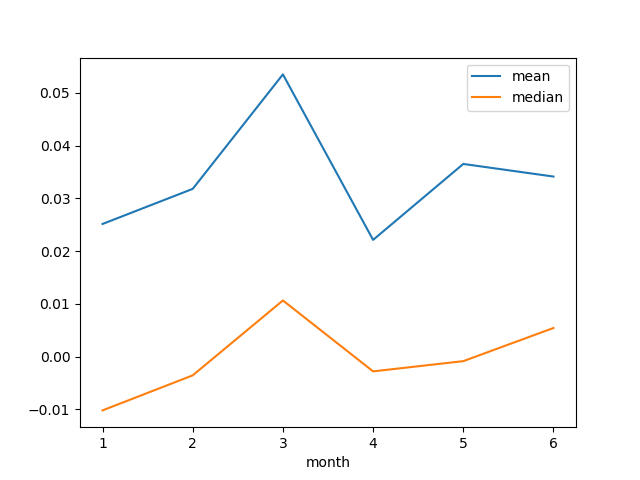

In [23]:
grouped['error'][['mean','median']].plot();

In [10]:
grouped=df[df.year<2018][['month','error','abserror']].groupby('month').aggregate(['mean','std','median','count'])
grouped

error                             abserror                      \
           mean       std    median  count      mean       std    median   
month                                                                      
1      0.031681  0.339242 -0.002383  23652  0.189470  0.283175  0.106725   
2      0.031464  0.349190 -0.001924  20018  0.194660  0.291598  0.107088   
3      0.075978  0.423551  0.004421  29528  0.229919  0.363735  0.112805   
4      0.040024  0.358127  0.001606  21517  0.198678  0.300636  0.109723   
5      0.047334  0.358163  0.008540  22361  0.201042  0.300170  0.110107   
6      0.041664  0.345968  0.008938  23836  0.194449  0.289168  0.106674   
7      0.034770  0.344980  0.005746  25463  0.194325  0.287152  0.106411   
8      0.032920  0.338763  0.001640  26086  0.194781  0.279112  0.108013   
9      0.026258  0.346471 -0.007435  25520  0.196585  0.286504  0.109556   
10     0.024862  0.343525 -0.005358  23527  0.193219  0.285118  0.107961   
11     0.019603  0.345677 -0.012361  22892  0.198503  0.283675  0.112995   
12     0.017044  0.349402 -0.016337  21510  0.199571  0.287301  0.113888   

              
       count  
month         
1      23652  
2      20018  
3      29528  
4      21517  
5      22361  
6      23836  
7      25463  
8      26086  
9      25520  
10     23527  
11     22892  
12     21510

In [26]:
grouped=pd.pivot_table(df,columns='month',index=['year'],values=['error'],aggfunc='median')
grouped

error                                                              \
month        1         2         3         4         5         6         7    
year                                                                          
2007  -0.009486 -0.004123 -0.002862  0.010152  0.005767  0.003151 -0.002362   
2008  -0.011412 -0.008261 -0.009119 -0.004993  0.008938  0.001784  0.012976   
2009  -0.035308 -0.015235 -0.020762 -0.004980  0.007477  0.011393  0.013615   
2010  -0.004841 -0.007901  0.012153 -0.013607  0.002944  0.006347  0.000492   
2011   0.005163  0.004009 -0.007877  0.005663  0.005160  0.009495  0.008168   
2012  -0.000815 -0.000361  0.006135 -0.000881  0.010062  0.011479  0.005959   
2013   0.011182  0.009281  0.020866  0.013283  0.009383  0.020294  0.006968   
2014   0.021938  0.008836  0.006134  0.008038  0.016150  0.011432 -0.000474   
2015   0.013462 -0.001777  0.022709 -0.000167  0.009142  0.010928  0.012513   
2016   0.001477 -0.005069 -0.002257 -0.001057  0.023087  0.019092  0.007206   
2017  -0.007125 -0.000673 -0.007557  0.003974  0.002373 -0.001775  0.003783   
2018  -0.010213 -0.003565  0.010631 -0.002811 -0.000876  0.005411       NaN   

                                                         
month        8         9         10        11        12  
year                                                     
2007   0.002600 -0.007036 -0.002267 -0.007666 -0.003795  
2008   0.013111  0.005465  0.000356  0.000485 -0.009245  
2009   0.022105 -0.001185  0.018488 -0.015880  0.000152  
2010  -0.016632 -0.028143  0.002854 -0.006238 -0.017514  
2011  -0.002452 -0.003523 -0.012525 -0.022064 -0.018829  
2012  -0.000055  0.004403 -0.019287 -0.011773 -0.026822  
2013  -0.002522 -0.014251 -0.017115 -0.024744 -0.042024  
2014  -0.001271 -0.016792 -0.011526 -0.022006 -0.014557  
2015  -0.003261 -0.006677 -0.015816 -0.024691 -0.029990  
2016  -0.001860 -0.008658 -0.006592 -0.003478 -0.023048  
2017   0.005709 -0.001170  0.001027 -0.003124 -0.002651  
2018        NaN       NaN       NaN       NaN       NaN

In [28]:
grouped.T.corr()

year      2007      2008      2009      2010      2011      2012      2013  \
year                                                                         
2007  1.000000  0.302988  0.506883  0.133245  0.433103  0.311261  0.396455   
2008  0.302988  1.000000  0.764435 -0.080271  0.220822  0.359680  0.004821   
2009  0.506883  0.764435  1.000000 -0.042576  0.080707 -0.008203 -0.165287   
2010  0.133245 -0.080271 -0.042576  1.000000  0.181735  0.290664  0.532395   
2011  0.433103  0.220822  0.080707  0.181735  1.000000  0.785319  0.815366   
2012  0.311261  0.359680 -0.008203  0.290664  0.785319  1.000000  0.843929   
2013  0.396455  0.004821 -0.165287  0.532395  0.815366  0.843929  1.000000   
2014  0.359329 -0.184488 -0.258389  0.445047  0.795141  0.612306  0.839230   
2015  0.219940  0.063588 -0.176788  0.547357  0.758175  0.848587  0.928709   
2016  0.460942  0.442242  0.196641  0.567601  0.681567  0.776687  0.702073   
2017  0.649678  0.726904  0.781449 -0.267809  0.296661  0.095066 -0.011477   
2018  0.247124  0.209410  0.385029  0.782534 -0.528804  0.654742  0.823874   

year      2014      2015      2016      2017      2018  
year                                                    
2007  0.359329  0.219940  0.460942  0.649678  0.247124  
2008 -0.184488  0.063588  0.442242  0.726904  0.209410  
2009 -0.258389 -0.176788  0.196641  0.781449  0.385029  
2010  0.445047  0.547357  0.567601 -0.267809  0.782534  
2011  0.795141  0.758175  0.681567  0.296661 -0.528804  
2012  0.612306  0.848587  0.776687  0.095066  0.654742  
2013  0.839230  0.928709  0.702073 -0.011477  0.823874  
2014  1.000000  0.791994  0.629804 -0.075460 -0.681250  
2015  0.791994  1.000000  0.659440 -0.128607  0.526410  
2016  0.629804  0.659440  1.000000  0.208157  0.166743  
2017 -0.075460 -0.128607  0.208157  1.000000 -0.175457  
2018 -0.681250  0.526410  0.166743 -0.175457  1.000000

<IPython.core.display.Javascript object>


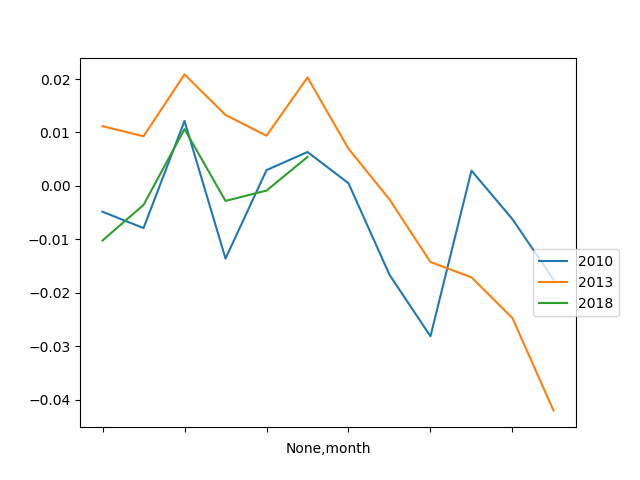

In [36]:
grouped.T[[2010,2013,2018]].plot()
plt.legend(loc='upper center', bbox_to_anchor=(1.0, 0.5))

<IPython.core.display.Javascript object>


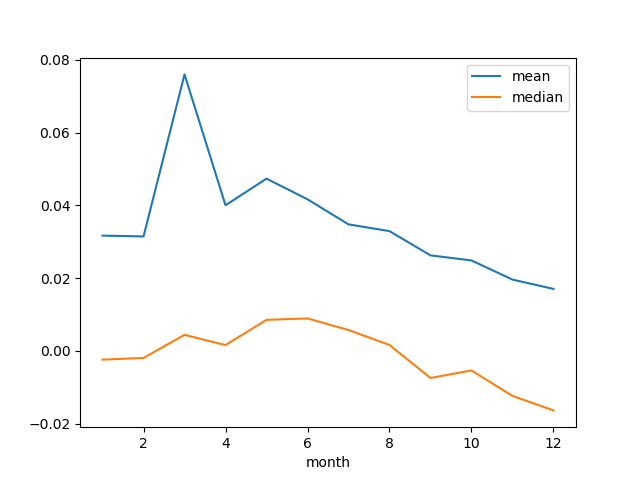

In [11]:
grouped['error'][['mean','median']].plot();

<IPython.core.display.Javascript object>


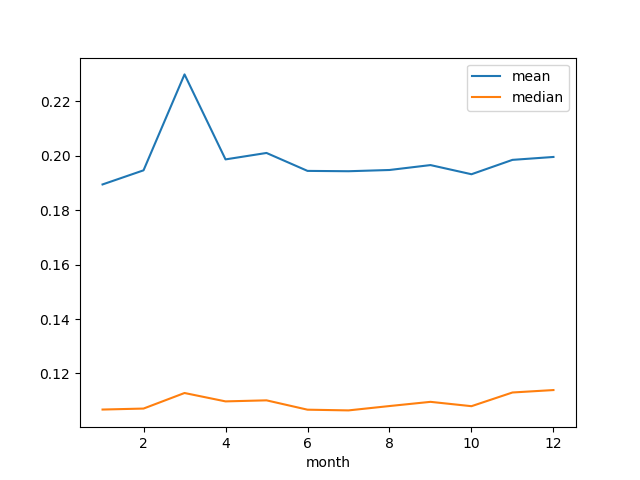

In [12]:
grouped['abserror'][['mean','median']].plot();

In [13]:
df.head()

error  longitude   latitude  month  year  abserror
parcelid                                                       
94620761 -0.051021 -73.920677  40.806026      3  2007  0.051021
94620993 -0.066020 -73.914062  40.814056      1  2007  0.066020
94621029 -0.046585 -73.923805  40.805916      9  2007  0.046585
94621037 -0.067500 -73.923378  40.805737      6  2007  0.067500
94621040 -0.041512 -73.923134  40.805634      3  2007  0.041512

In [14]:
def plot3d(subdf,col):
    import os
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from scipy.interpolate import griddata


    fig = plt.figure()
    ax = Axes3D(fig)
    # my_data = np.genfromtxt('2014_0.01_v3_HDF5.txt', delimiter = ',',     skip_header = 1)
    # my_data[my_data==0] = np.nan 
    # my_data = my_data[~np.isnan(my_data).any(axis=1)]
    X = subdf.longitude.values
    Y = subdf.latitude.values
    Z = subdf[col].values
    xi = np.linspace(X.min(),X.max(),(len(Z)/3))
    yi = np.linspace(Y.min(),Y.max(),(len(Z)/3))
    zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='nearest')

    xig, yig = np.meshgrid(xi, yi)

    surf = ax.plot_surface(xig, yig, zi, cmap='gist_earth')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('error ')
    #ax.set_zlim3d(Z.min(),Z.max())

In [15]:
subdf=df.iloc[np.random.permutation(range(len(df)))[:2000]]

In [16]:
subdf=df[df.year==2018]
subdf=df.iloc[np.random.permutation(range(len(subdf)))[:2000]]

<IPython.core.display.Javascript object>


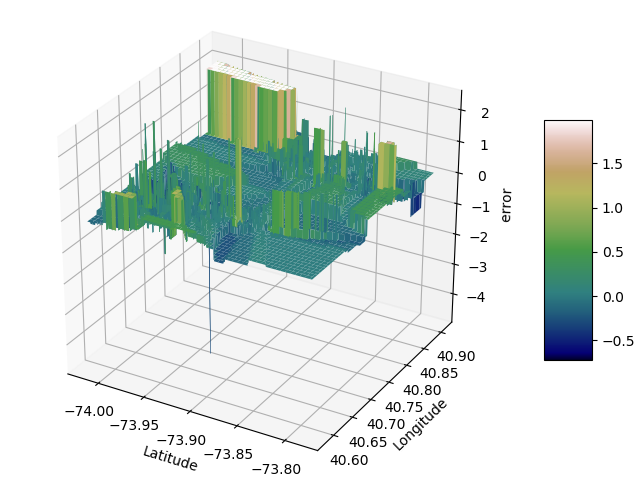

In [17]:
plot3d(subdf,'error')

<IPython.core.display.Javascript object>


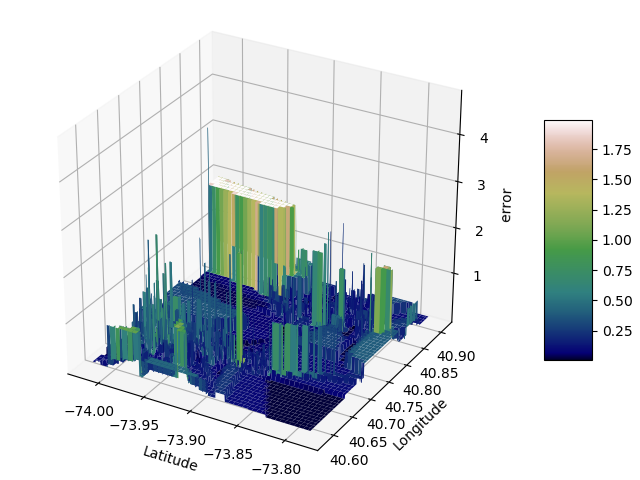

In [18]:
plot3d(subdf,'abserror')

In [19]:
subdf=df[df.year==2017]
subdf=df.iloc[np.random.permutation(range(len(subdf)))[:2000]]

<IPython.core.display.Javascript object>


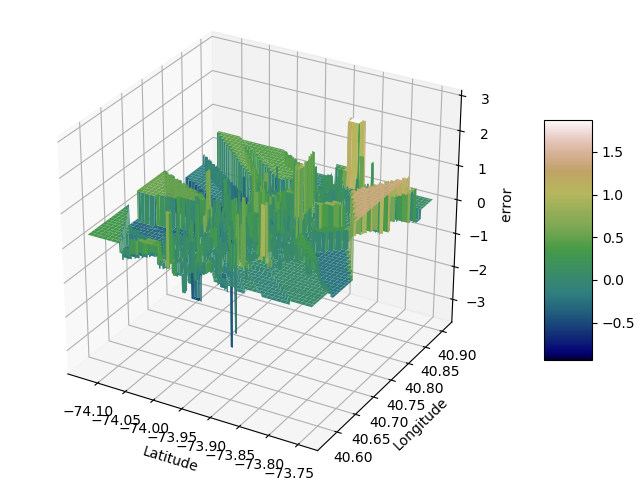

In [20]:
plot3d(subdf,'error')

<IPython.core.display.Javascript object>


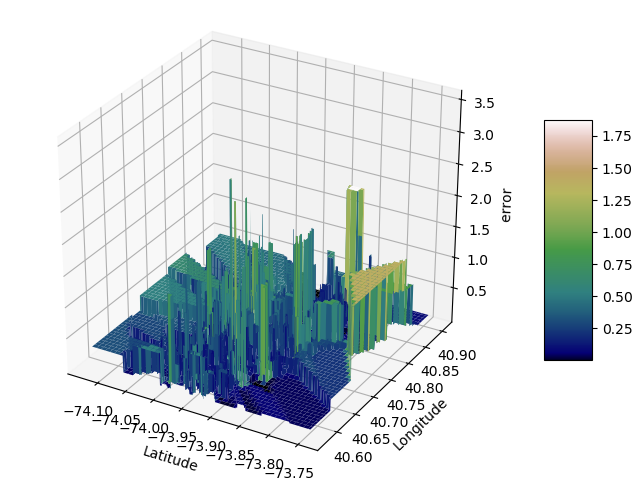

In [21]:
plot3d(subdf,'abserror')